# Milestone 2

1. Write a function that computes a 4-parameter geometric registration (global scale, rotation, and translations along two axes) between two mid-coronal MRI slices from two different subjects (a fixed image and a moving image). This step will consist of following sub-steps.

    – a function that takes in an input (moving) image, 4 transformation parameters (global scale, rotation, and translations along two axes) and output (fixed image) grid size, and computes the output (moved) image. The output image has a size of the output grid size and pixel values are obtained by resampling the input image onto the output grid via applying the geometric transformation: a global scale multiplied with a rotation matrix, followed by a translation. Outside-of-grid-range values can default to zero.
    
    – a loss function that takes three inputs: a length-4 vector of geometric transformation parameters, a fixed image, and a moving image. The output should be equal to the sum of squared differences between the geometrically transformed moved image and the fixed image.
    
    – an optimization module that minimizes the loss function for a given input image pair (fixed and moving). This module should return two things: the transformed moving image and the optimal geometric transformation parameters.

In [7]:
import pickle
import numpy as np
from PIL import Image
import nibabel as nib
from scipy import ndimage
from scipy.stats import mode
from scipy.optimize import fmin
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib inline

def transformFunc(inpImg, transVector, shape, method='linear'):
    """
    Returns the geometrically transformed image of the inpImg. 
    
    Param:
        inpImg : array type 
        shape  : (y,x)-tuple of output shape
        transVector : [ gs, rot, tx, ty]
            - gs : global scale factor
            - rot: counter-clockwise rotation in degrees
            - tx : shift in the x-direction
            - ty : shift in the y direction
    """
    gs, rot, Tx, Ty = transVector
    rad = rot*np.pi/180
    b = np.linspace(-256//2, 256//2, 256)
    bb, aa = np.array(np.meshgrid(b,b))
    R = np.array([[np.cos(rad), -np.sin(rad)],[np.sin(rad), np.cos(rad)]])

    #Transform the coordinates
    c_1 = R[0,0]*(1/gs)*aa + R[0,1]*(1/gs)*bb
    c_2 = R[1,0]*(1/gs)*aa + R[1,1]*(1/gs)*bb
    b_orig = np.linspace(-128, 128, 256)
    f = RegularGridInterpolator((b_orig, b_orig), inpImg, bounds_error = False,fill_value=0,method=method)
    x_out = f(np.stack((c_1+Tx, c_2+Ty), axis=2))
    return x_out


def lossFunc(transVector, movingImg, fixedImg):
    """
    Returns the sum of squared differences between the geometrically transformed and the fixed image. 
    
    Param:
        movingImg : array type 
        fixedImg  : array type
        transVector : [ gs, rot, tx, ty]
            - gs : global scale factor, [gy, gx] or a float
            - rot: counter-clockwise rotation in degrees
            - tx : shift in the x-direction
            - ty : shift in the y direction
    """
    transImg = transformFunc(movingImg, transVector, fixedImg.shape)
    diff = np.subtract(fixedImg, transImg)
    diff_square = np.square(diff)
    diff_square_sum = np.sum(diff_square)
    return np.sqrt(diff_square_sum)


def optimize(movingImg, fixedImg, initial=[1, 0, 0, 0]):
    """
    Returns the optimally translated image and the optimization parameters. 
    
    Param:
        moving : array type 
        fixed  : array type
        initial: [ gs, rot, tx, ty] - initial optimization parameters
            - gs : global scale factor
            - rot: counter-clockwise rotation in degrees
            - tx : shift in the x-direction
            - ty : shift in the y direction
    """
    params = fmin(lossFunc, initial, args=(movingImg, fixedImg), 
                xtol=0.0001, ftol=0.0001,
                maxfun = 10000, maxiter = 10000, 
                full_output=0, disp=0)
    optimizedImg = transformFunc(movingImg, params, fixedImg.shape)
    return optimizedImg, params

2.  Use  your  registration  tool  to  resample  each  training  image  (moving)  onto  eachvalidation image (fixed) (i.e., you need to run 12 registration instances).  

3. Apply the registration results (optimal transformations) to resample the manual segmentations of each training subject onto the validation subject grids (use nearest neighbor interpolation).

In [8]:
# load the original data
cases = pickle.load( open( "cases.pkl", "rb" ) )

# split the data into two groups
validationCases = {}
trainingCases = {}
for case in cases:
    if case["type"] == 'Validation':
        if case["name"][:7] not in validationCases:
            validationCases[case["name"][:7]] = []
        validationCases[case["name"][:7]].append(case)
    elif case["type"] == 'Training':
        if case["name"][:7] not in trainingCases:
            trainingCases[case["name"][:7]] = []
        trainingCases[case["name"][:7]].append(case)

# optimize images and add to main data structure
masterDict = {}
for vCName, validationCase in validationCases.items():
    fixedUnseg = validationCase[0]['slice']
    fixedSeg = validationCase[1]['slice']
    
    masterDict[vCName] = {  'name' : vCName,
                            'fixedSeg' : fixedSeg,
                            'fixedUnseg' : fixedUnseg,
                            'mappings': [] }
    
    for tCName, trainingCase in trainingCases.items():
        movingUnseg = trainingCase[0]['slice']
        movingSeg = trainingCase[1]['slice']
        
        optimizedUnseg, params = optimize(movingUnseg/np.max(movingUnseg)*255, fixedUnseg/np.max(fixedUnseg)*255)
        optimizedSeg = transformFunc(movingSeg, params, fixedSeg.shape, method="nearest")
        
        mapping = { "name" : tCName,
                    'params' : params,
                    'movingSeg':movingSeg,
                    'optimizedSeg':optimizedSeg,
                    'movingUnseg':movingUnseg,
                    'optimizedUnseg':optimizedUnseg }
        masterDict[vCName]['mappings'].append(mapping)
        
        print(tCName+'-->'+vCName, params) # print the progress

IBSR_05-->IBSR_15 [ 1.04914710e+00 -1.92696606e-06 -3.91602713e-05  5.98432347e-05]
IBSR_02-->IBSR_15 [ 0.99306156  0.00444392 -0.01845875  0.01759394]
IBSR_03-->IBSR_15 [ 1.06033247e+00 -1.13183988e-05  1.17712123e-04 -4.04562821e-05]
IBSR_04-->IBSR_15 [ 1.15811798  1.78815125 -0.63808988 -1.97808877]
IBSR_01-->IBSR_15 [ 1.04856996e+00  6.78014271e-05  3.15014582e-05 -2.63348516e-05]
IBSR_06-->IBSR_15 [ 1.08311306  0.24055544 -0.33114179 -3.86088098]
IBSR_05-->IBSR_07 [ 0.92718349  2.45937302  1.13908378 -5.44893645]
IBSR_02-->IBSR_07 [ 0.88751134  1.96527353  0.60874434 -1.45969881]
IBSR_03-->IBSR_07 [ 1.05982565e+00  8.55801512e-05  5.06146366e-05 -3.61157880e-05]
IBSR_04-->IBSR_07 [ 1.07273667e+00  1.70661283e-04 -1.49531005e-04  4.38633820e-05]
IBSR_01-->IBSR_07 [ 0.90844007  0.51645962  0.3697252  -0.63659199]
IBSR_06-->IBSR_07 [ 0.91032307  2.88203866  2.25913224 -2.02013098]


Visualizesome slices of these results.  You need to show that your registration works - i.e.,plot results for before the registration and after the registration.

<Figure size 432x288 with 0 Axes>

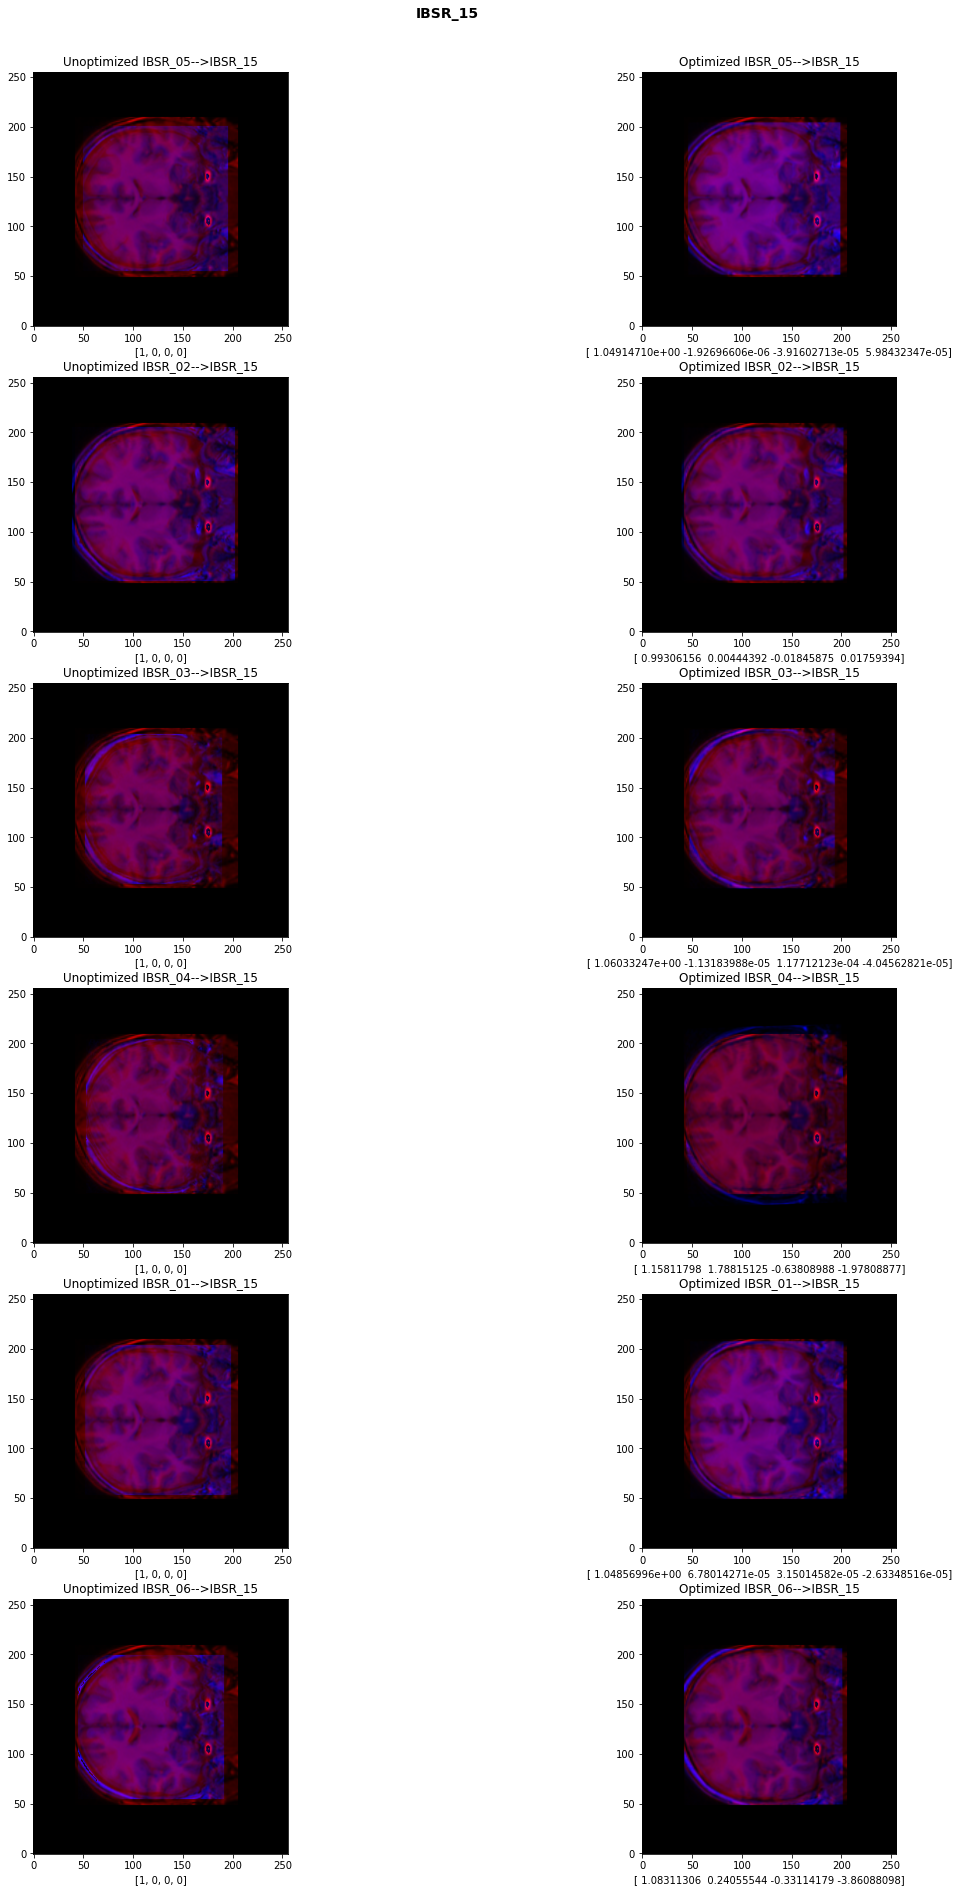

<Figure size 432x288 with 0 Axes>

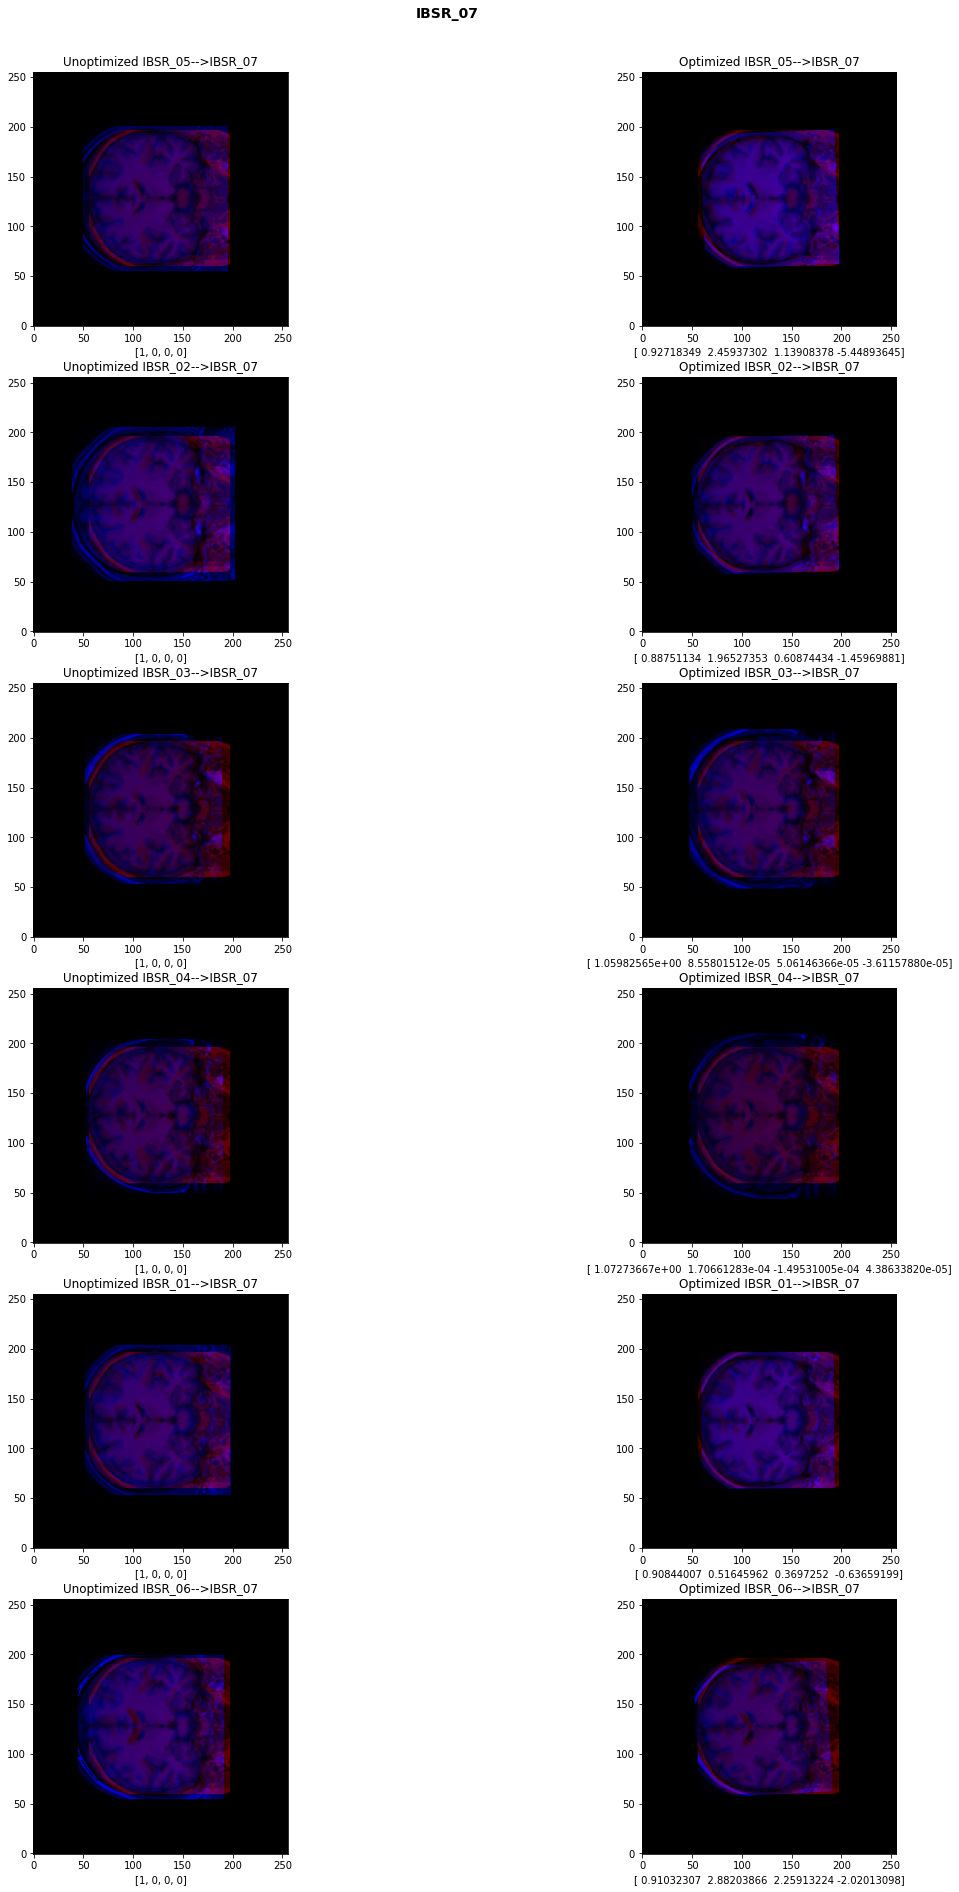

In [9]:
rgbArray = np.zeros((256,256,3), 'uint8')
for keyValidation, valueValidation in masterDict.items():  
    fig = plt.figure()
    fig, ax = plt.subplots(6, 2, figsize=(20,30), squeeze=False)
    fig.suptitle(keyValidation, fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95)
    rgbArray[..., 0] = valueValidation['fixedUnseg']  # red
    
    for i, each in enumerate(valueValidation['mappings']):
        title = each['name']+'-->'+keyValidation
        
        rgbArray[..., 2] = each['movingUnseg']  # blue
        unsegmentedBefore = Image.fromarray(rgbArray)
        
        ax[i, 0].set_title('Unoptimized '+title)
        ax[i,0].imshow(unsegmentedBefore, origin="lower")
        ax[i,0].set_xlabel(str([1, 0, 0, 0]))
        
        rgbArray[..., 2] = each['optimizedUnseg']  # blue
        unsegmentedAfter = Image.fromarray(rgbArray)
        ax[i, 1].set_title('Optimized '+title)
        ax[i,1].imshow(unsegmentedAfter, origin="lower")
        ax[i,1].set_xlabel(str(each['params']))


4. For every pixel on validation subject grid, compute the most frequent training label – this is called majority voting based label fusion. You can implement any tie-break strategy you want. This is a crude segmentation of the validation subjects.

In [10]:
def getModeLabels(layers):
    imgLabel = np.zeros((layers.shape[0],layers.shape[1]))
    for y in range(layers.shape[0]):
        for x in range(layers.shape[1]):
            label = mode(layers[y,x,:])
            imgLabel[y,x] = label[0]
    return imgLabel

for key, value in masterDict.items():
    # build the optimized segmented layers
    layers = np.zeros((256,256,len(value['mappings'])))
    for i in range(len(value['mappings'])):
        layers[:,:,i] = value['mappings'][i]['optimizedSeg']
    
    # add the voting based label fusion
    masterDict[key]["labeledSeg"] = getModeLabels(layers)      

5. Write a function that computes the Jaccard overlap index for a given region of interest (ROI) between an input manual segmentation and an automatic segmentation. The Jaccard index is defined as the ratio between the area of the intersection and the area of the union, where the intersection and union are defined with respect to the manual segmentation and an automatic segmentation.

In [11]:
def jaccard(manualSeg, autoSeg, roi):
    manSegROI = np.where(manualSeg == roi, 1, 0)
    autoSegROI = np.where(autoSeg == roi, 1, 0)
    unionROI = np.logical_or(manSegROI, autoSegROI)
    interROI = np.logical_and(manSegROI, autoSegROI)
    return np.sum(interROI)/np.sum(unionROI)

6. Compute the Jaccard index for your automatic validation subject segmentations. Compile these in a table and print. Only consider following regions of interest (both left and right): Cerebral-White-Matter and Cerebral-Cortex.

    ROI = 2  --> Left-Cerebral-White-Matter      |  ROI = 41 --> Right-Cerebral-White-Matter  
    ROI = 3  --> Left-Cerebral-Cortex            |  ROI = 42 --> Right-Cerebral-Cortex 
    
      

In [12]:
ROIS = {2:'Left-Cerebral-White-Matter', 3:'Left-Cerebral-Cortex',
       41:'Right-Cerebral-White-Matter', 42:'Right-Cerebral-Cortex'}

for key, value in masterDict.items():
    manualSeg = value['fixedSeg']
    autoSeg = value['labeledSeg']
    
    print("Validation: "+key)
    for k,v in ROIS.items():
        print(v, "\t\t jaccard=",jaccard(manualSeg, autoSeg, k))
    print("\n")

Validation: IBSR_15
Left-Cerebral-White-Matter 		 jaccard= 0.5122072745391131
Left-Cerebral-Cortex 		 jaccard= 0.3702090592334495
Right-Cerebral-White-Matter 		 jaccard= 0.5375835189309577
Right-Cerebral-Cortex 		 jaccard= 0.43097135472754683


Validation: IBSR_07
Left-Cerebral-White-Matter 		 jaccard= 0.526809148856393
Left-Cerebral-Cortex 		 jaccard= 0.4755775577557756
Right-Cerebral-White-Matter 		 jaccard= 0.6003773584905661
Right-Cerebral-Cortex 		 jaccard= 0.5368655057428677


